# 버전 설명 

전처리 
- 평균과 편차 
- 시계열 window  : Lot 단위 
- Min Max scaling 

모델 
- Isolation Forest 사용 

- 작업 내용 
  - 기존에 작업한 것 거의 그대로 하고 모델만 isolation forest 적용 
  - 우선은 따로 파라미터 튜닝 없이 isolation forest적용 후 결과 보고 튜닝 진행 
  - 변수의 경우 편차 사용 + train-test-split 350:200:226 비율로 진행 
  - 추후 하이퍼 파라미터 다시 고려 
- Ver2 
  - 기존에 69,4 로 reshape하던거 풀고 -1,69*4로 진행 
  - 그리고 각각 0,1로 판단하되 단편 행만으로 판단하는 것 아니라 Lot에서 1 횟수가 일정 치만큼 넘어 갈 경우 이상이라 판단 
  - 일정 치는 predict 후 정상 데이터의 분포 보고 판단 

## Score history

Ver1 : 
  - 원래변수 + 편차 변수 
  - minmax + n=120 Iforest 
  - rcall = 0.5
  - precision = 1 

Ver2 :
  - Ver1 에 Date timestamp로 변형 후 변수로 넣음
  - 성능 하락 -> 파기 

Ver3 : 
  - n_estimators=20
  - rand=20
  - predicted =53
  - recall = 0.6666666666666666
  - precision = 0.07547169811320754
  - [14, 154, 171, 296] 4
  - 
  - n_estimators=20
  - rand=15
  - predicted =19
  - recall = 0.5
  - precision = 0.15789473684210525
  - [154, 278, 296] 3

Ver4 : Kelvin Temp
- Fail

데이터 로드 

In [ ]:
!unzip /content/drive/MyDrive/DataSet/전해탈지/Dataset.zip

라이브러리 모듈 

In [383]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from glob import glob 
from tqdm import tqdm

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest

# CSV 데이터 병합 

## csv 리스트 디렉토리 

In [384]:
csv_list_dir = glob('/content/data/*.csv')
csv_list_dir.sort()
csv_list_dir.remove( '/content/data/Error Lot list.csv',)

## input 데이터 로드 

In [385]:
def add_date(df,dir):
  date = dir[-14:-4]
  df['date'] = date
  return df 
  
#init 
dir = csv_list_dir[0]
df = pd.read_csv(dir)
df = add_date(df,dir)

for dir in csv_list_dir[1:]:
  temp_df = pd.read_csv(dir)
  temp_df = add_date(temp_df,dir)
  df = pd.concat([df,temp_df],axis=0)

## output 데이터 로드

In [386]:
error = pd.read_csv('/content/data/Error Lot list.csv')
error = error.fillna(0)
error['Date'] = error['Date'].apply(lambda x : x.replace('-','.')) # input 데이터랑 date 형태 통일 

## error 데이터 parsing 

In [387]:
df['error']=0

def add_error(df,error,index):
  date = error.iloc[index,:]['Date']
  LoT = error.iloc[index,:]['LoT']
  LoT2 = error.iloc[index,:]['LoT2']
  df.loc[(df['date']==date)&(df['Lot']==LoT),'error']=1
  df.loc[(df['date']==date)&(df['Lot']==LoT2),'error']=1
  return df
  
for index in range(len(error)):
  df = add_error(df,error,index)

15.0
15


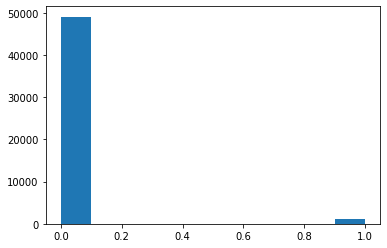

In [388]:
#정상적으로 입력 됬는지 확인 
print(len(df[df['error']==1])/69)
temp = np.array(error)[:,2:]
print(len(temp[temp!=0]))
plt.hist(df['error'])
plt.show()

In [389]:
np.array(df).shape

(50094, 8)

# 전처리

## Absolute Temperature

In [299]:
# df['Temp'] = df['Temp'].apply(lambda x : x+273)

## 편차 게산 

편차 계산을 위한 각 변수들 평균 계산 

In [390]:
columns = ['pH','Temp','Current']
mean_values = np.array(df[columns]).mean(axis=0).astype(np.int)
print('Ph = ' ,mean_values[0])
print('Temp = ', mean_values[1])
print('Current = ', mean_values[2])

Ph =  10
Temp =  45
Current =  7


In [391]:
def diff_cal(columns,values):
  if columns == 'pH':
    return_value = abs(10-values)
  if columns == 'Temp':
    return_value = abs(45-values)
  if columns == 'Current' :
    return_value = abs(7-values)
  return return_value

def time_change(value):
  import time
  import datetime
  s = value
  s = time.mktime(datetime.datetime.strptime(s, "%Y/%m/%d").timetuple())
  return s 

df['Current_diff'] = df['Current'].apply(lambda x : diff_cal('Current',x))
df['Temp_diff'] = df['Temp'].apply(lambda x : diff_cal('Temp',x))
df['pH_diff'] = df['pH'].apply(lambda x : diff_cal('pH',x))
df['Timestamp'] = df['date'].apply(lambda x : x.replace('.','/')).map(time_change)

df.head()

,Index,Lot,Time,pH,Temp,Current,date,error,Current_diff,Temp_diff,pH_diff,Timestamp
0,1,1,오후 4:29:15.0,10.37,42.87,7.34,2021.09.06,0,0.34,2.13,0.37,1.630886e+09
1,2,1,오후 4:29:20.0,10.90,42.70,8.26,2021.09.06,0,1.26,2.30,0.90,1.630886e+09
2,3,1,오후 4:29:25.0,9.61,42.37,8.46,2021.09.06,0,1.46,2.63,0.39,1.630886e+09
3,4,1,오후 4:29:30.0,10.32,45.85,8.04,2021.09.06,0,1.04,0.85,0.32,1.630886e+09
4,5,1,오후 4:29:35.0,10.36,44.18,7.23,2021.09.06,0,0.23,0.82,0.36,1.630886e+09


## 컬럼제거

In [397]:
# cols = ['pH','Temp','Current','Current_diff','Temp_diff','pH_diff','Timestamp','error']
cols = ['pH','Temp','Current','Current_diff','Temp_diff','pH_diff','error']
# cols = ['pH','Temp','Current','error']
input = np.array(df[cols])

## 시계열 분할 

In [398]:
input = input.reshape(-1,69,7)
input.shape

(726, 69, 7)

output 제작

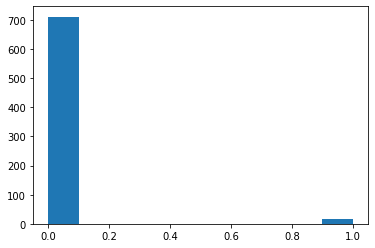

In [394]:
output = np.zeros(726)
for index in range(726):
  temp = input[index]
  if temp[:,6].sum()==69:
    output[index]=1

plt.hist(output)
plt.show()

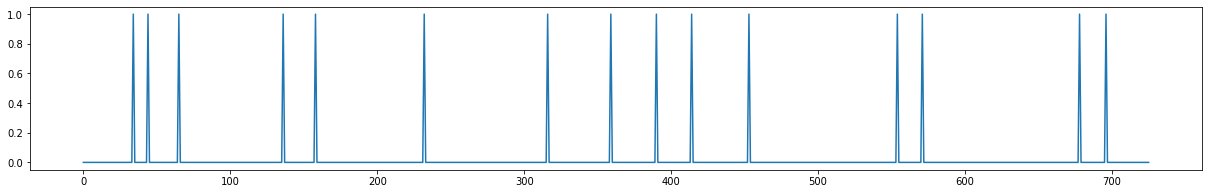

In [332]:
plt.figure(figsize = (21,3))
plt.plot(np.arange(len(output)),output)
plt.show()

train : 400, test rest 

## Train - test - valid 분할 

In [399]:
input = input[:,:,:-1].reshape(-1,69*6)
input.shape

train_x = input[:400,]
train_y = output[:400,]

test_x = input[400:,]
test_y = output[400:,]

In [400]:
print(train_x.shape,train_y.shape)

(400, 414) (400,)


## scaling

In [401]:
max = np.max(train_x,axis=0)
min = np.min(train_x,axis=0)

std = np.std(train_x,axis=0)
mean = np.mean(train_x,axis=0)

def scaling(df,max,min,mean,std,mode):
  if mode == 'minmax':
    scaled_df = (df-min)/(max-min)
    return scaled_df
  elif mode == 'std':
    scaled_df = (df-mean)/std
    return scaled_df

train_x = scaling(train_x,max,min,mean,std,'std')
test_x = scaling(test_x,max,min,mean,std,'std')

print(train_x.shape,train_y.shape)

(400, 414) (400,)


#모델

In [403]:
result = np.where(test_y==1)[0]
result

def check_recall(predicted,result):
  n = 0 
  target = []
  for i in predicted:
    if i in result:
      n+=1
      target.append(i)
    else:
      pass
  if n!= 0 :
    print('-------')
    print(f'predicted ={len(predicted)}')
    print(f'recall = {n/len(result)}')
    print(f'precision = {n/len(predicted)}')
    print(target,n)
    print('-------')
  else:
    pass

## Isolation Forest

In [419]:
# for i in [120]:
for i in [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]:
  print(f'n_estimators={i}')
  print(f'rand={rand}')
  IF = IsolationForest(random_state=0,n_estimators=i,contamination = 'auto')
  IF.fit(train_x,train_y)
  y_ = IF.predict(test_x)
  predicted = np.where(y_==-1)[0]
  check_recall(predicted,result)
  print('\n')

n_estimators=10
rand=60


n_estimators=20
rand=60
-------
predicted =9
recall = 0.16666666666666666
precision = 0.1111111111111111
[296] 1
-------


n_estimators=30
rand=60
-------
predicted =12
recall = 0.16666666666666666
precision = 0.08333333333333333
[296] 1
-------


n_estimators=40
rand=60
-------
predicted =9
recall = 0.16666666666666666
precision = 0.1111111111111111
[296] 1
-------


n_estimators=50
rand=60
-------
predicted =7
recall = 0.16666666666666666
precision = 0.14285714285714285
[296] 1
-------


n_estimators=60
rand=60
-------
predicted =6
recall = 0.16666666666666666
precision = 0.16666666666666666
[296] 1
-------


n_estimators=70
rand=60
-------
predicted =5
recall = 0.16666666666666666
precision = 0.2
[296] 1
-------


n_estimators=80
rand=60
-------
predicted =6
recall = 0.16666666666666666
precision = 0.16666666666666666
[296] 1
-------


n_estimators=90
rand=60
-------
predicted =3
recall = 0.16666666666666666
precision = 0.3333333333333333
[296] 1
-------




### 분포확인 

In [275]:
IF.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 200,
 'n_jobs': None,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

## Local Outlier Factor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

for i in [1,3,5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]:
  LF = LocalOutlierFactor(n_neighbors=i,novelty='True')
  LF.fit(train_x,train_y)
  y_ = LF.predict(test_x)
  predicted = np.where(y_==-1)[0]
  check_recall(predicted,result)


## XGBoost

In [ ]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

In [ ]:
for i in [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]:
  xgb = GradientBoostingClassifier(n_estimators= i, learning_rate = 0.1, max_depth = 1, random_state = 0)
  xgb.fit(train_x,train_y)
  xgb.predict(test_x)
  predicted = np.where(y_==-1)[0]
  check_recall(predicted,result)

-------
predicted =43
recall = 0.16666666666666666
precision = 0.023255813953488372
[296] 1


## K-fold

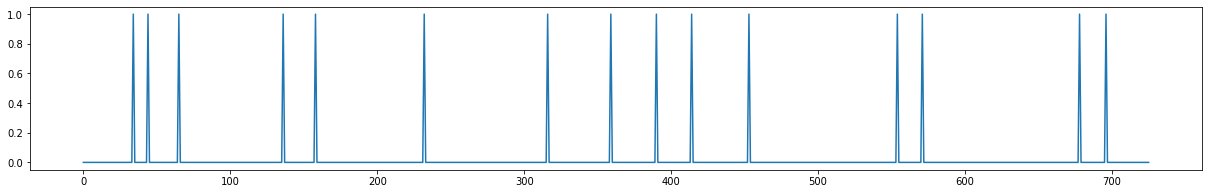

In [423]:
input = np.array(df[cols])

input = input.reshape(726,69,-1)

output = np.zeros(726)
for index in range(726):
  temp = input[index]
  if temp[:,-1].sum()==69:
    output[index]=1


plt.figure(figsize = (21,3))
plt.plot(np.arange(len(output)),output)
plt.show()

In [424]:
input = input[:,:,:-1].reshape(-1,69*6)

train_x = input[:400,]
train_y = output[:400,]

test_x = input[400:,]
test_y = output[400:,]

In [425]:
max = np.max(train_x,axis=0)
min = np.min(train_x,axis=0)

std = np.std(train_x,axis=0)
mean = np.mean(train_x,axis=0)

def scaling(df,max,min,mean,std,mode):
  if mode == 'minmax':
    scaled_df = (df-min)/(max-min)
    return scaled_df
  elif mode == 'std':
    scaled_df = (df-mean)/std
    return scaled_df

train_x = scaling(train_x,max,min,mean,std,'std')
test_x = scaling(test_x,max,min,mean,std,'std')

In [427]:
train_x_1 = input[:100,]
train_y_1 = output[:100,]

train_x_2 = input[:200,]
train_y_2 = output[:200,]

train_x_3 = input[:300,]
train_y_3 = output[:300,]

train_x_4 = input[:400,]
train_y_4 = output[:400,]

train_x_5 = input[100:200,]
train_y_5 = output[100:200,]

train_x_6 = input[100:300,]
train_y_6 = output[100:300,]

train_x_7 = input[100:400,]
train_y_7 = output[100:400,]

train_x_8 = input[200:400,]
train_y_8 = output[200:400,]

train_x_9 = input[200:300,]
train_y_9 = output[200:300,]

train_x_9 = input[300:400,]
train_y_9 = output[300:400,]

In [434]:
train_lists = [[train_x_1,train_y_1],
               [train_x_2,train_y_2],
               [train_x_3,train_y_3],
               [train_x_4,train_y_4],
               [train_x_5,train_y_5],
               [train_x_6,train_y_6],
               [train_x_7,train_y_7],
               [train_x_8,train_y_8],
               [train_x_9,train_y_9]]

In [430]:
a,b = [[train_x,train_y]][0]

In [437]:
for i in range(1,9):
  train_x,train_y = train_lists[i]
  print(train_x.shape)
  IF = IsolationForest(random_state=0,n_estimators=120,contamination = 'auto')
  IF.fit(train_x,train_y)
  y_ = IF.predict(test_x)
  predicted = np.where(y_==-1)[0]
  check_recall(predicted,result)
  print('\n')

(200, 414)
-------
predicted =326
recall = 1.0
precision = 0.018404907975460124
[14, 53, 154, 171, 278, 296] 6
-------


(300, 414)
-------
predicted =326
recall = 1.0
precision = 0.018404907975460124
[14, 53, 154, 171, 278, 296] 6
-------


(400, 414)
-------
predicted =326
recall = 1.0
precision = 0.018404907975460124
[14, 53, 154, 171, 278, 296] 6
-------


(100, 414)
-------
predicted =326
recall = 1.0
precision = 0.018404907975460124
[14, 53, 154, 171, 278, 296] 6
-------


(200, 414)
-------
predicted =326
recall = 1.0
precision = 0.018404907975460124
[14, 53, 154, 171, 278, 296] 6
-------


(300, 414)
-------
predicted =326
recall = 1.0
precision = 0.018404907975460124
[14, 53, 154, 171, 278, 296] 6
-------


(200, 414)
-------
predicted =326
recall = 1.0
precision = 0.018404907975460124
[14, 53, 154, 171, 278, 296] 6
-------


(100, 414)
-------
predicted =326
recall = 1.0
precision = 0.018404907975460124
[14, 53, 154, 171, 278, 296] 6
-------


